In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import imageio

# Gen some data

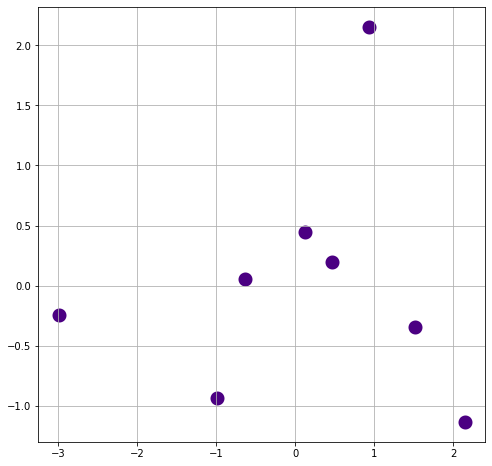

In [2]:
data_dim = 2
data_count = 8
data = np.random.randint(data_count, size=(data_count, data_dim))
data = np.unique(data, axis=0)
sample = 'randint'

data = np.random.normal(size=(data_count, data_dim))
sample = 'normal'

plt.figure(figsize=(8, 8))
plt.scatter(data[:, 0], data[:, 1], color='indigo', linewidth=8)
plt.grid(True)
plt.show()

# Search 2-dim simplex info

In [3]:
def get_edges_radiuses(data, norm=np.linalg.norm):
    """
    Returns radiuses, which are half of distance between verticies
    
    Parameters:
    -------
    data : np.2darray
        Income data, array of verticies.
    
    norm : function
        Matrix or vector norm.
    
    Returns:
    --------
    res : Dictionary
        Keys are radiuses, values are lists of vertex pairs.
    """
    distance = data*np.ones([data.shape[0], data.shape[0], data.shape[1]])
    distance = distance - np.transpose(distance, axes=(1, 0, 2))
    distance = norm(distance, axis=2)
    diameters = np.unique(distance[distance!= 0])
    
    res = {}
    for d in diameters:
        r = 0.5*d
        res.update({r : np.where(np.triu(distance) == d)})
        res[r] = list(np.array(res[r]).transpose())
        res[r] = [tuple(i) for i in res[r]]
    return res

In [4]:
def get_edges(data, norm=np.linalg.norm):
    """
    Returns dict: keys are vertex pairs? values are halfs of lengths.
    
    Parameters:
    -------
    data : np.2darray
        Income data, array of verticies.
    
    norm : function
        Matrix or vector norm.
    
    Returns:
    --------
        res : Dictionary
    """
    res = {}
    for i in itertools.combinations(np.arange(len(data)), 2):
        a, b = data[[i]]
        res.update({tuple(i) : {'radius' : 0.5*norm(a - b)}})
    return res

# Search 3-dim simplex info

In [5]:
def get_triangle_radius(a, b, c, norm=np.linalg.norm):
    """
    Returns radius of circumscribed circle of triangle.
    
    Parameters:
    -------
    a : np.ndarray
        Vertex
        
    b : np.ndarray
        Vertex
        
    c : np.ndarray
        Vertex
    
    scalar : function
        Dot product of two arrays.
    
    norm : function
        Matrix or vector norm.
    
    Returns:
    --------
    r : float
        Radius.
    """
    al = norm(a-b)
    bl = norm(b-c)
    cl = norm(c-a)
    p = 0.5*(al+bl+cl)
    top = al*bl*cl
    bot = 4 * np.sqrt(p*(p-al)*(p-bl)*(p-cl))
    r = top/bot
    return r

In [6]:
def get_triangle_center(a, b, c):
    """
    Returns center of circumscribed circle of triangle.
    
    Parameters:
    -------
    a : np.ndarray
        Vertex
        
    b : np.ndarray
        Vertex
        
    c : np.ndarray
        Vertex
    
    Returns:
    --------
    v : np.ndarray
        Center.
    """
    # Будем исходить из того, что точки - двумерные
    # Центром описанной около треугольника окружности является точка, в которой 
    # пересекаются все серединные перпендикуляры, проведённые к сторонам треугольника.
    m = []
    l = []
    for i in itertools.combinations([a, b, c], 2):
        va = i[0]
        vb = i[1]
        m.append(va - vb)
        l.append(0.5*((va+vb)*(va-vb)).sum())
    m = np.array(m)
    l = np.array(l)
    v = np.linalg.solve(m[:-1], l[:-1])
    return v

In [7]:
def point_in_triangle(a, b, c, p):
    """
    Returns True if point p is in triangle abc.
    
    Parameters:
    -----------
    a : np.ndarray
        Vertex
        
    b : np.ndarray
        Vertex
        
    c : np.ndarray
        Vertex
    
    o : np.ndarray
        Vertex
        
    Returns:
    --------
        g : bool
    
    """
    # Будем исходить из того, что точки - двумерные
    g = True
    for i in itertools.permutations([a, b, c], 3):
        va, vb, vc = i
        f = lambda x: ((x-va)*(vb-va)).sum()
        if f(p)*f(vc) < 0:
            g = False
            break
    return g

A: [-0.6369486   0.05185006] 
B: [ 2.14194767 -1.1348667 ] 
C: [-2.99485921 -0.24724781] 

R: 5.157833911702433
O: [-1.18430403 -5.07685862] 

O is in ABC: False


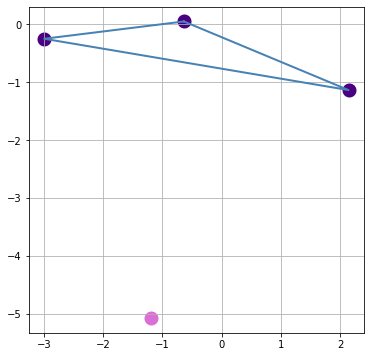

In [8]:
a, b, c = data[[0, 1, 2]]
print('A:', a, '\nB:', b, '\nC:', c, '\n')
print('R:', get_triangle_radius(a, b, c))
print('O:', get_triangle_center(a, b, c), '\n')

o = get_triangle_center(a, b, c)
print('O is in ABC:', point_in_triangle(a, b, c, o))

plt.figure(figsize=(6, 6))
plt.scatter(a[0], a[1], color='indigo', linewidth=8)
plt.scatter(b[0], b[1], color='indigo', linewidth=8)
plt.scatter(c[0], c[1], color='indigo', linewidth=8)
plt.scatter(o[0], o[1], color='orchid', linewidth=8)
plt.plot([a[0], b[0], c[0], a[0]], [a[1], b[1], c[1], a[1]], linewidth=2, color='steelblue')
plt.grid(True)
plt.show()

In [9]:
def get_triangles(data, norm=np.linalg.norm):
    """
    Returns dict: keys are triples of indices, values are dicts contains radius and center 
    
    Parameters:
    -----------
    data : np.2darray
        Income data, array of verticies.
    
    norm : function
        Matrix or vector norm.
    
    Returns:
    --------
    res : Dictionary
    """
    res = {}
    for i in itertools.combinations(np.arange(len(data)), 3):
        a, b, c = data[[i]]
        res.update({tuple(i) : {'radius' : get_triangle_radius(a, b, c, norm), 'center' : get_triangle_center(a, b, c)}})
    return res

# Radius research

In [10]:
def copy_dict(d):
    """
    Returns copy of dictionary.
    
    Parameters:
    -----------
    d : dict
    
    Returns:
    --------
    r : dict
    """
    r = {}
    for key in d.keys():
        if type(d[key]) == dict:
            r.update({key : copy_dict(d[key])})
        else:
            try:
                r.update({key : d[key].copy()})
            except AttributeError:
                r.update({key : d[key]})
    return r

In [11]:
def sort_dict(d):
    """
    Sort dict keys.
    
    Parameters:
    -----------
        d : dict
        
    Returns:
    --------
        r : dict
    """
    r = {}
    for key in np.sort(list(d.keys())):
        r.update({key : d[key]})
    return r

In [12]:
def get_radius_data_2d(data, norm=np.linalg.norm):
    """
    Returns dict: keys are radiuses.
    
    Parameters:
    -----------
    data : np.2darray
        Income data, array of verticies.
    
    norm : function
        Matrix or vector norm.
    
    Returns:
    --------
        res : Dictionary
    --------
    """
    res = {0 : {'edges' : [], 'triangles' : [], 'centers' : []}}
    edges = get_edges(data, norm)
    for edge in edges:
        radius = edges[edge]['radius']
        try:
            res[radius]['edges'].append(edge)
        except KeyError:
            res.update({radius : {'edges' : [edge], 'triangles' : [], 'centers' : []}})
    triangles = get_triangles(data, norm)
    for triangle in triangles:
        radius = triangles[triangle]['radius']
        center = triangles[triangle]['center']
        try:
            res[radius]['triangles'].append(triangle)
            res[radius]['centers'].append(center)
        except KeyError:
            res.update({radius : {'edges' : [], 'triangles' : [triangle], 'centers' : [center]}})
    res = sort_dict(res)
    return res

# Check simplex status

In [13]:
# Stolen directly from https://web.archive.org/web/20111108065352/https://www.cs.mun.ca/~rod/2500/notes/numpy-arrays/numpy-arrays.html
def perp(a):
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

def seg_intersect(a1, a2, b1, b2):
    da = a2-a1
    db = b2-b1
    dp = a1-b1
    dap = perp(da)
    denom = np.dot( dap, db)
    num = np.dot( dap, dp )
    return (num / denom.astype(float))*db + b1

def seg_intersect_bool(a1, a2, b1, b2):
    c = seg_intersect(a1, a2, b1, b2)
    ga = ((c - a1)*(a2 - c) > 0).all()
    gb = ((c - b1)*(b2 - c) > 0).all()
    return ga and gb

In [14]:
def edge_is_new(data, edge, old=[]):
    """
    
    """
    g = True
    a0, a1 = data[[edge]]
    for b in old:
        b0, b1 = data[[b]]
        if seg_intersect_bool(a0, a1, b0, b1):
            g = False
            break
    return g

In [15]:
def get_list(d, border, key):
    d_keys = np.array(list(d.keys()))
    d_keys = d_keys[d_keys <= border]
    res = []
    for d_key in d_keys:
        res.extend(d[d_key][key])
    return res

In [16]:
def radius_spaces(data, norm=np.linalg.norm):
    radiuses = get_radius_data_2d(data)
    space_now = {0 : np.arange(len(data)), 1 : [], 2 : []}
    res = {}
    for key_radius in list(radiuses.keys()):
        changes = key_radius == 0 
        # Проверка новых рёбер
        old_edges = space_now[1]
        pot_edges = radiuses[key_radius]['edges']
        new_edges = []
        for edge in pot_edges:
            if edge_is_new(data, edge, old_edges):
                new_edges.append(edge)
                changes = True
        if changes:
            space_now[1].extend(new_edges)
            res.update({key_radius : copy_dict(space_now)})
        
        
    return res

In [17]:
spaces_rad = radius_spaces(data)
len(spaces_rad)

/tmp/ipykernel_17039/3234434522.py:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  a, b = data[[i]]
/tmp/ipykernel_17039/3050924908.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  a0, a1 = data[[edge]]
/tmp/ipykernel_17039/3050924908.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b0, b1 = data[[b]]


18

# Visualization

In [18]:
def draw_balls(data, radius, color='orchid', linewidth=0, alpha=0.5, circle_points=24, fill=True, ax=plt):
    """
    Plots balls arround points from data.
    
    Parameters:
    -----------
    data : np.ndarray or list of np.ndarrays
        List of points.
        
    radius : float
        Ball radius.
        
    color : color or rgba tuple
        
    linewidth : scalar
        
    alpha : float
        The alpha blending value, between 0 (transparent) and 1 (opaque).
            
    circle_points : int
        Number of points in circle. (If fill is True, then that will be number of ponts in top and bot arc)
        
    fill : bool
        Fill circle if True.
        
    ax : matplotlib.pyplot or Axes class
    """
    if fill:
        arc_x = radius*np.cos(np.pi*np.arange(circle_points+1)/circle_points)
        arc_y1 = radius*np.sin(np.pi*np.arange(circle_points+1)/circle_points)
        arc_y2 = radius*np.sin(-np.pi*np.arange(circle_points+1)/circle_points)
        for point in data:
            ax.fill_between(x=point[0] + arc_x, y1=point[1] + arc_y1, y2=point[1] + arc_y2,
                            color=color, linewidth=linewidth, alpha=alpha)
    else:
        circle_x = radius*np.cos(2*np.pi*np.arange(circle_points+1)/circle_points)
        circle_y = radius*np.sin(2*np.pi*np.arange(circle_points+1)/circle_points)
        for point in data:
            ax.plot(point[0] + circle_x, point[1] + circle_y, color=color, linewidth=linewidth, alpha=alpha)

In [19]:
def draw_simplicies(data, edges=[], triangles=[],
                    node_color='indigo', node_width=8, node_alpha=1,
                    edge_color='steelblue', edge_width=4, edge_alpha=1,
                    triangle_color='aquamarine', triangle_alpha=0.7, ax=plt):
    """
    Plots nodes edges and triangles of all simplicies.
    
    Parameters:
    -----------
    data : np.ndarray or list of np.ndarrays
        List of points (nodes).
            
    edges : list of tuples
        List of node pairs.
            
    triangles : list of tuples
        List of triangle triples.
            
    node_color : color or rgba tuple
        Node color.
            
    node_width : scalar
        Linewidth of nodes.
        
    node_alpha : float
        The alpha blending value for node, between 0 (transparent) and 1 (opaque).

    edge_color : color or rgba tuple
        Edge color.
            
    edge_width : scalar
        Linewidth of edges.
        
    edge_alpha : float
        The alpha blending value for edge, between 0 (transparent) and 1 (opaque).
            
    triangle_color : color or rgba tuple
        Triangle fill color.
        
    node_alpha : float
        The alpha blending value for filled triangle, between 0 (transparent) and 1 (opaque).
        
    ax : matplotlib.pyplot or Axes class
    """
    for triangle in triangles:
        xs = [data[i][0] for i in triangle]
        ys = [data[i][1] for i in triangle]
        ax.fill(xs, ys, color=triangle_color, alpha=triangle_alpha)
    for edge in edges:
        p0 = data[edge[0]]
        p1 = data[edge[1]]
        ax.plot([p0[0], p1[0]], [p0[1], p1[1]], color=edge_color, linewidth=edge_width, alpha=edge_alpha)
    for point in data:
        ax.scatter(point[0], point[1], color=node_color, linewidth=node_width, alpha=node_alpha)

In [20]:
filetemplate = 'simplex2d'
filename = filetemplate + '_' + sample + '_dim' + str(data_dim) + '_count' + str(data_count)
filename

'simplex2d_normal_dim2_count8'

In [21]:
vis_rads = np.arange(0, 2.01, 0.025)
len(vis_rads)

81

In [22]:
for rad in vis_rads:
    radius = np.array(list(spaces_rad.keys()))
    radius = radius[radius <= rad][-1]
    
    edges = spaces_rad[radius][1]
    triangles = spaces_rad[radius][2]
    
    plt.figure(figsize=(12, 12))
    plt.title('$R = ' + str('{:.3f}'.format(rad)) +'$', fontdict={'fontsize':24})
    draw_balls(data, rad, color='orchid', alpha=0.15, ax=plt)
    draw_simplicies(data, edges=edges, triangles=triangles)
    plt.grid(True)
    plt.savefig('pics/' + filename + str(rad).replace('.', '_') + '.png')
    plt.close()

In [23]:
images = [imageio.imread('pics/' + filename + str(radius).replace('.', '_') + '.png') for radius in vis_rads]
imageio.mimsave(filename + '.gif', images)